# Part 2: RNN

### Upload the dataset for creation of RNN, and check characteristics

In [2]:
import columns
!pip install -U keras-tuner



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

ModuleNotFoundError: No module named 'matplotlib'

In [2]:
import pandas as pd
import numpy as np

# Cyclic encoding helper
def cyclic_encode(df, col, max_val):
    df[f'{col}_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[f'{col}_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    return df

# Load dataset
file_path = "/Users/filiporlikowski/Documents/EngeneeringProject/training_of_price_predictive_model_with_data_from_relevant_periods"
df = pd.read_csv(f"{file_path}/merged_dataset_with_org_cat_values.csv")

# If 'date' column exists, extract month
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['month'] = df['date'].dt.month
    df = cyclic_encode(df, 'month', 12)
else:
    print("❗ Column 'date' not found in dataset.")

# Optional: Save or inspect
# df.to_csv("with_cyclic_encoding.csv", index=False)
print(df[['month', 'month_sin', 'month_cos']].head())


   month     month_sin  month_cos
0      6  1.224647e-16       -1.0
1      6  1.224647e-16       -1.0
2      6  1.224647e-16       -1.0
3      6  1.224647e-16       -1.0
4      6  1.224647e-16       -1.0


Now we have understood the basic characterstics of the dataset, and we know the following metadata:

**Data Fields**

- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather -
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

### Exploratory Data Analysis

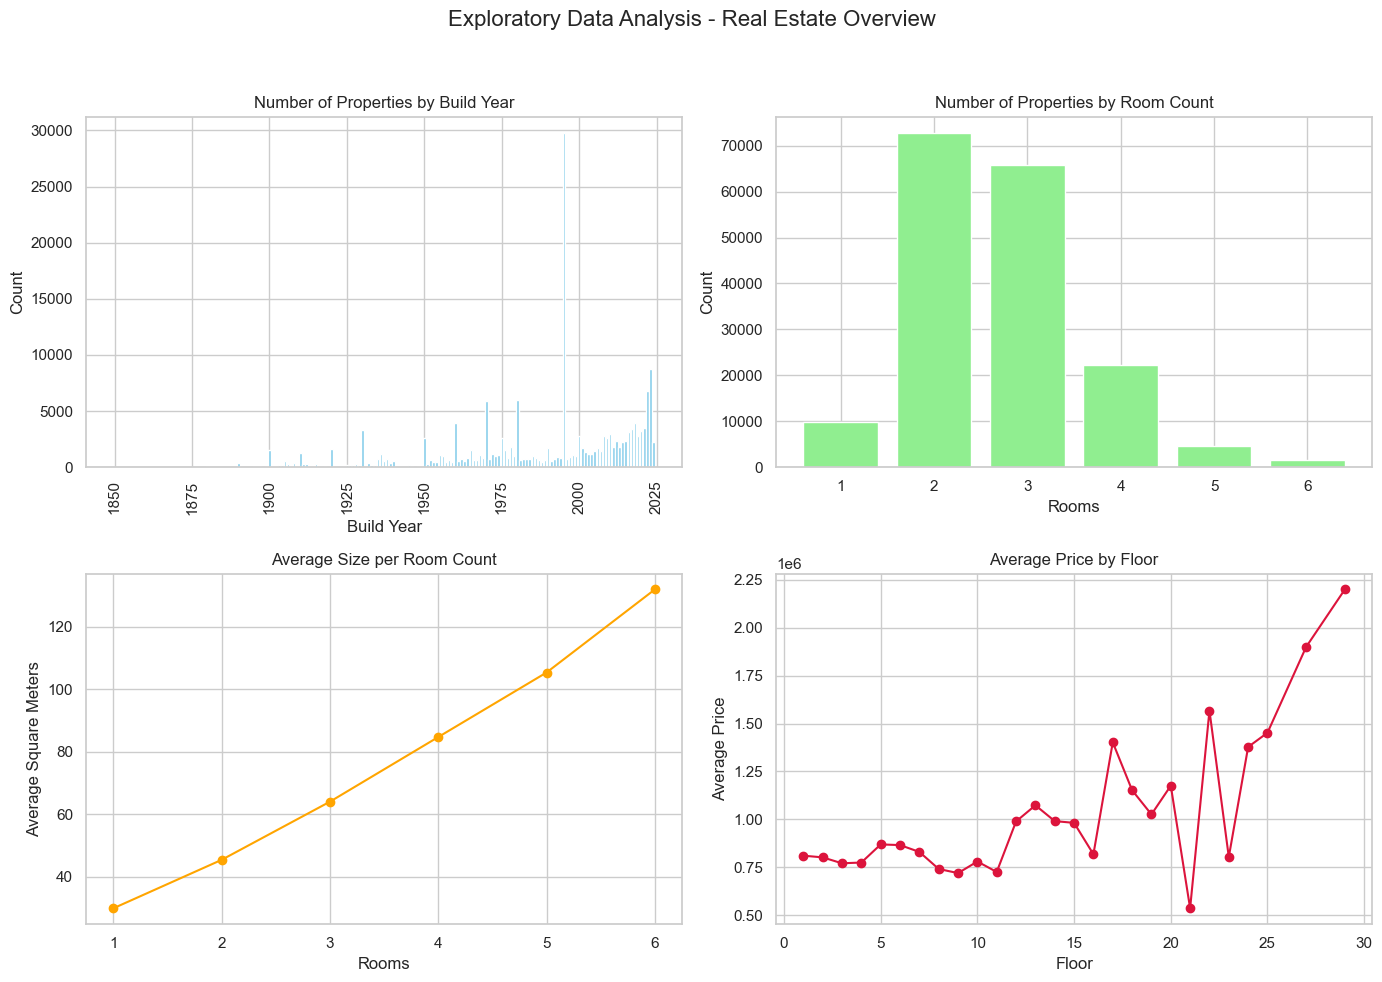

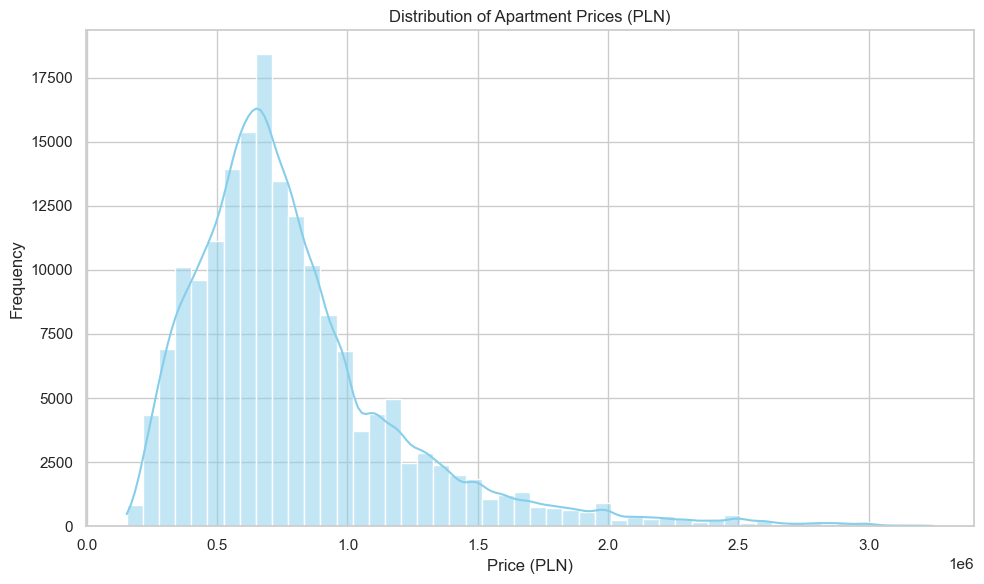

Summary Statistics:
count    1.766630e+05
mean     7.939881e+05
std      4.148964e+05
min      1.526200e+05
25%      5.297000e+05
50%      6.990000e+05
75%      9.450000e+05
max      3.250000e+06
Name: price, dtype: float64

Price Distribution Table:
  Price Range (PLN)  Count
0             <200k    569
1         200k–400k  21636
2         400k–600k  40866
3         600k–800k  49212
4           800k–1M  28852
5           1M–1.5M  24859
6           1.5M–2M   7184
7               >2M   3485


In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


df = df.dropna(subset=['buildYear', 'floor', 'rooms', 'price', 'squareMeters'])


fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Exploratory Data Analysis - Real Estate Overview", fontsize=16)


build_year_counts = df['buildYear'].astype(int).value_counts().sort_index()
axs[0, 0].bar(build_year_counts.index, build_year_counts.values, color='skyblue')
axs[0, 0].set_title("Number of Properties by Build Year")
axs[0, 0].set_xlabel("Build Year")
axs[0, 0].set_ylabel("Count")
axs[0, 0].tick_params(axis='x', labelrotation=90)


room_counts = df['rooms'].value_counts().sort_index()
axs[0, 1].bar(room_counts.index, room_counts.values, color='lightgreen')
axs[0, 1].set_title("Number of Properties by Room Count")
axs[0, 1].set_xlabel("Rooms")
axs[0, 1].set_ylabel("Count")


avg_sq_per_room = df.groupby('rooms')['squareMeters'].mean()
axs[1, 0].plot(avg_sq_per_room.index, avg_sq_per_room.values, marker='o', color='orange')
axs[1, 0].set_title("Average Size per Room Count")
axs[1, 0].set_xlabel("Rooms")
axs[1, 0].set_ylabel("Average Square Meters")


avg_price_per_floor = df.groupby('floor')['price'].mean()
axs[1, 1].plot(avg_price_per_floor.index, avg_price_per_floor.values, marker='o', color='crimson')
axs[1, 1].set_title("Average Price by Floor")
axs[1, 1].set_xlabel("Floor")
axs[1, 1].set_ylabel("Average Price")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True, bins=50, color='skyblue')
plt.title('Distribution of Apartment Prices (PLN)')
plt.xlabel('Price (PLN)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

summary_stats = df['price'].describe()
print("Summary Statistics:")
print(summary_stats)

bin_edges = [0, 200000, 400000, 600000, 800000, 1000000, 1500000, 2000000, df['price'].max()]
bin_labels = ['<200k', '200k–400k', '400k–600k', '600k–800k', '800k–1M', '1M–1.5M', '1.5M–2M', '>2M']

# Cut into bins
df['price_bin'] = pd.cut(df['price'], bins=bin_edges, labels=bin_labels, include_lowest=True)


price_dist_table = df['price_bin'].value_counts().sort_index()
price_dist_table = price_dist_table.reset_index()
price_dist_table.columns = ['Price Range (PLN)', 'Count']

print("\nPrice Distribution Table:")
print(price_dist_table)


/var/folders/ss/1qcx7q7n50z1ltqpq2jfcvb40000gn/T/ipykernel_99571/752365633.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=var, palette="pastel")


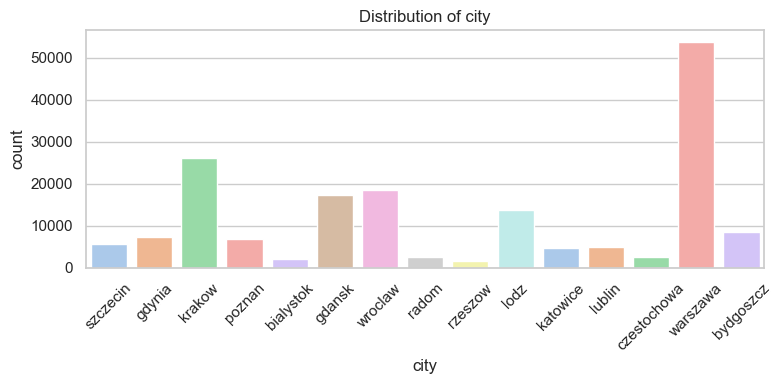

/var/folders/ss/1qcx7q7n50z1ltqpq2jfcvb40000gn/T/ipykernel_99571/752365633.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=var, palette="pastel")


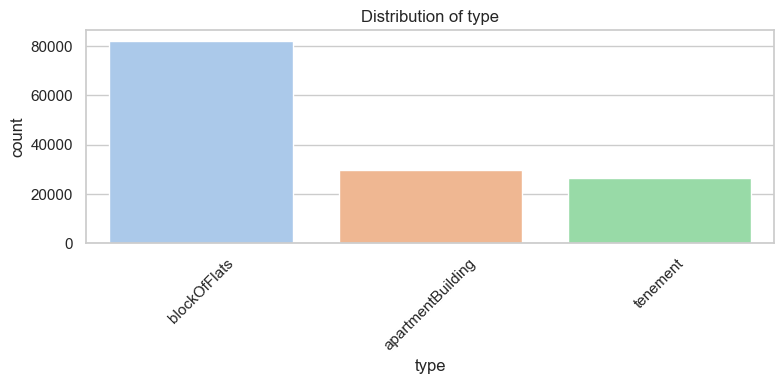

/var/folders/ss/1qcx7q7n50z1ltqpq2jfcvb40000gn/T/ipykernel_99571/752365633.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=var, palette="pastel")


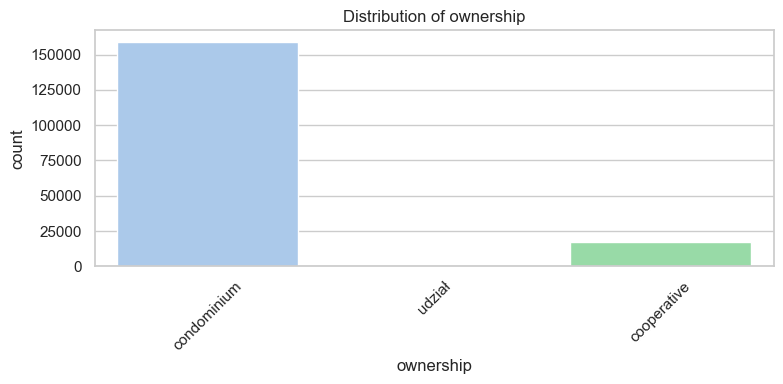

/var/folders/ss/1qcx7q7n50z1ltqpq2jfcvb40000gn/T/ipykernel_99571/752365633.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=var, palette="pastel")


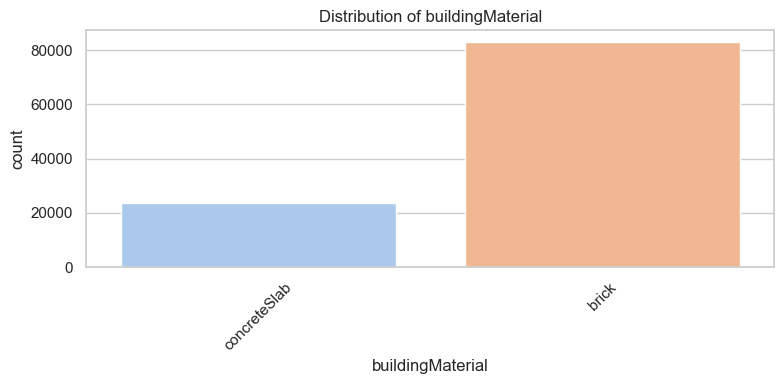

/var/folders/ss/1qcx7q7n50z1ltqpq2jfcvb40000gn/T/ipykernel_99571/752365633.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=var, palette="pastel")


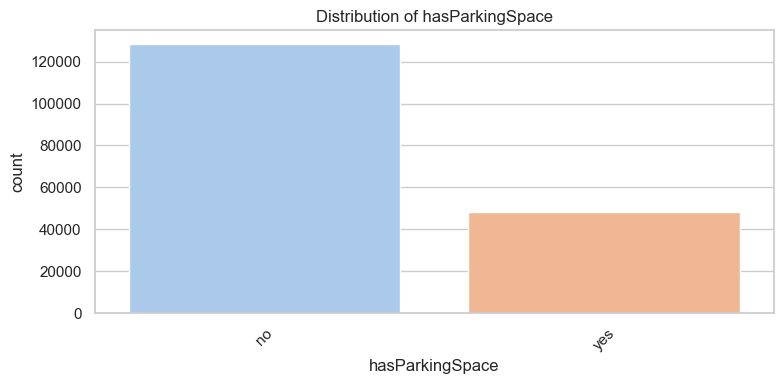

/var/folders/ss/1qcx7q7n50z1ltqpq2jfcvb40000gn/T/ipykernel_99571/752365633.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=var, palette="pastel")


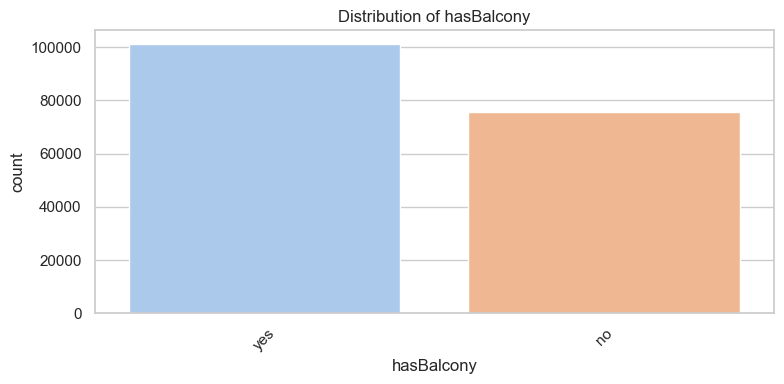

/var/folders/ss/1qcx7q7n50z1ltqpq2jfcvb40000gn/T/ipykernel_99571/752365633.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=var, palette="pastel")


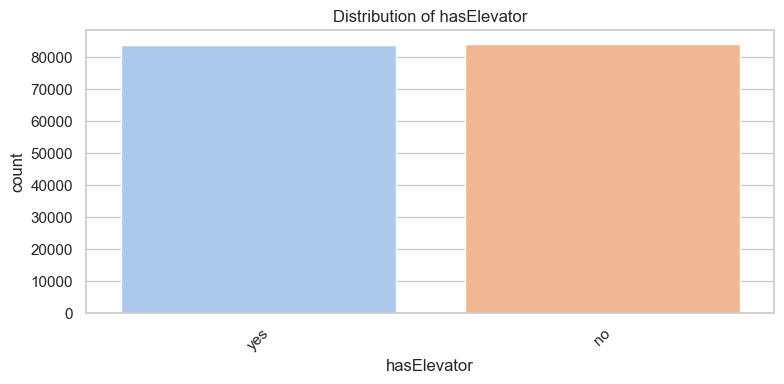

/var/folders/ss/1qcx7q7n50z1ltqpq2jfcvb40000gn/T/ipykernel_99571/752365633.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=var, palette="pastel")


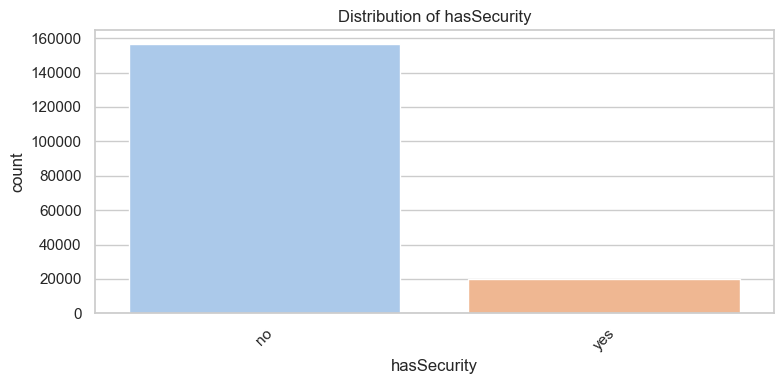

/var/folders/ss/1qcx7q7n50z1ltqpq2jfcvb40000gn/T/ipykernel_99571/752365633.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=var, palette="pastel")


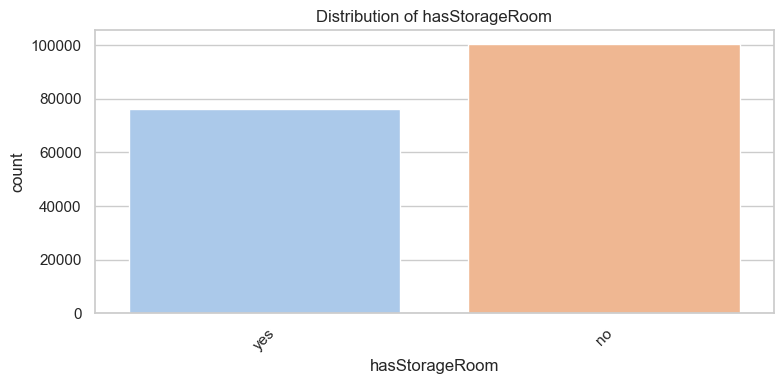

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


categorical_vars = [
    'city', 'type', 'ownership', 'buildingMaterial',
    'hasParkingSpace', 'hasBalcony', 'hasElevator',
    'hasSecurity', 'hasStorageRoom'
]

# Set plot style
sns.set(style="whitegrid")

# Plot each categorical variable
for var in categorical_vars:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=var, palette="pastel")
    plt.title(f'Distribution of {var}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### Data Preprocessing

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Load dataset
file_path = "merged_dataset_with_org_cat_values.csv"
df = pd.read_csv(file_path)

# Columns to keep
selected_features = [
    'squareMeters', 'rooms', 'floorCount', 'buildYear',
    'longitude', 'centreDistance', 'poiCount',
    'distance_to_train_1', 'distance_to_train_3', 'distance_to_primary_2'
]

# Define target and features
y = df['price']
X = df[selected_features].copy()  # only keep selected columns

# Split first to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ----- NUMERIC IMPUTATION -----
num_imputer = SimpleImputer(strategy='median')
X_train = pd.DataFrame(num_imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(num_imputer.transform(X_test), columns=X_test.columns)

print("Train columns:", X_train.columns.tolist())
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train columns: ['squareMeters', 'rooms', 'floorCount', 'buildYear', 'longitude', 'centreDistance', 'poiCount', 'distance_to_train_1', 'distance_to_train_3', 'distance_to_primary_2']
Train shape: (141330, 10)
Test shape: (35333, 10)


### **Useful Libraries and functions and a first model**

In [3]:
import sys
print(sys.executable)
print(sys.version)
#!pip install tensorflow

#import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, LSTM, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
import keras_tuner as kt

import sys
print(sys.executable)
print(sys.version)
#!pip install xgboost
import xgboost as xgb
print(xgb.__version__)

C:\Users\kubis\PycharmProjects\Database_Training\.venv1\Scripts\python.exe
3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:39) [MSC v.1935 64 bit (AMD64)]
C:\Users\kubis\PycharmProjects\Database_Training\.venv1\Scripts\python.exe
3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:39) [MSC v.1935 64 bit (AMD64)]
3.1.1


In [6]:
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=8,
    subsample=1,
    colsample_bytree=1,
    random_state=42
)

model.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          verbose=True)

model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

[0]	validation_0-rmse:400404.21282
[1]	validation_0-rmse:384754.18641
[2]	validation_0-rmse:369975.84597
[3]	validation_0-rmse:355996.88763
[4]	validation_0-rmse:342871.13275
[5]	validation_0-rmse:330478.89013
[6]	validation_0-rmse:318802.80650
[7]	validation_0-rmse:307815.61233
[8]	validation_0-rmse:297495.18459
[9]	validation_0-rmse:287785.23009
[10]	validation_0-rmse:278567.14808
[11]	validation_0-rmse:269972.61387
[12]	validation_0-rmse:261905.60046
[13]	validation_0-rmse:254288.63623
[14]	validation_0-rmse:247151.81788
[15]	validation_0-rmse:240424.31249
[16]	validation_0-rmse:234179.92560
[17]	validation_0-rmse:228214.65894
[18]	validation_0-rmse:222539.17689
[19]	validation_0-rmse:217156.86003
[20]	validation_0-rmse:212245.87022
[21]	validation_0-rmse:207632.16627
[22]	validation_0-rmse:203280.21907
[23]	validation_0-rmse:199261.36018
[24]	validation_0-rmse:195471.10986
[25]	validation_0-rmse:191866.77828
[26]	validation_0-rmse:188455.82132
[27]	validation_0-rmse:185226.88192
[2

## Better Model fo Improvement

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

# Assuming X and y are your features and target

# 1. Split data into train and test (if not done already)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Initialize XGBRegressor with early stopping parameters
model = xgb.XGBRegressor(
    objective='reg:squarederror',  # for regression
    random_state=42,
    n_estimators=1000,             # large number for early stopping
    learning_rate=0.05,            # smaller learning rate for better performance
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist'             # faster for large datasets
)

# 3. Fit model with early stopping
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    #early_stopping_rounds=50,   # stop if no improvement in 50 rounds
    verbose=10,
    #enable_categoricals=True
)

# 4. Predict on test set
y_pred = model.predict(X_test)

# 5. Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

# 6. Optional: Hyperparameter tuning with GridSearchCV
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [100, 300, 500]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)

# Evaluate best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print(f"MAE (best):  {mean_absolute_error(y_test, y_pred_best):.2f}")
print(f"RMSE (best): {np.sqrt(mean_squared_error(y_test, y_pred_best)):.2f}")
print(f"R² (best):   {r2_score(y_test, y_pred_best):.4f}")


[0]	validation_0-rmse:404345.48898
[10]	validation_0-rmse:299445.87561
[20]	validation_0-rmse:234448.72047
[30]	validation_0-rmse:201167.34839
[40]	validation_0-rmse:182326.25270
[50]	validation_0-rmse:170981.78130
[60]	validation_0-rmse:163673.97166
[70]	validation_0-rmse:158676.69280
[80]	validation_0-rmse:155615.45362
[90]	validation_0-rmse:153125.04173
[100]	validation_0-rmse:151025.81749
[110]	validation_0-rmse:149483.93791
[120]	validation_0-rmse:148027.94679
[130]	validation_0-rmse:146663.30300
[140]	validation_0-rmse:145347.74745
[150]	validation_0-rmse:144161.70306
[160]	validation_0-rmse:143169.83280
[170]	validation_0-rmse:142257.95278
[180]	validation_0-rmse:141432.34813
[190]	validation_0-rmse:140341.84427
[200]	validation_0-rmse:139238.15819
[210]	validation_0-rmse:138373.29371
[220]	validation_0-rmse:137516.54974
[230]	validation_0-rmse:136979.04427
[240]	validation_0-rmse:136220.94391
[250]	validation_0-rmse:135531.89935
[260]	validation_0-rmse:134745.26395
[270]	valida

Most prices are between 400k and 1M PLN, which aligns well with your MAE/RMSE. For those ranges:

An error of 51k PLN is around 5–10%, which is quite reasonable.
Error is more noticeable for lower-price flats (<400k) or luxury ones (>2M), but those are a small part of the dataset.
✅ Conclusion:
Your model is doing very well overall, especially in the price ranges that dominate your data.
If you want to improve performance for outliers (e.g., luxury apartments), you could consider:
Training separate models for different price segments.
Applying log(price) as the target to reduce skewness.

Next approach is to:
Train a global model on log(price) for all data.
Use an outlier-aware loss function (like Huber or Quantile loss with CatBoost or LightGBM).
add a feature like "is_premium" to the model instead of splitting the data.

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import xgboost as xgb

# === LOAD DATA ===
file_path = "merged_dataset_with_org_cat_values.csv"
df = pd.read_csv(file_path)

# === SELECTED FEATURES ===
selected_features = [
    'squareMeters', 'rooms', 'floorCount', 'buildYear',
    'longitude', 'centreDistance', 'poiCount',
    'distance_to_train_1', 'distance_to_train_3', 'distance_to_primary_2'
]

# Keep only selected features and target
df = df[selected_features + ['price']].copy()

# === PREP ===

# 1. Add 'is_premium' column
threshold = 720000
df['is_premium'] = (df['price'] > threshold).astype(int)

# 2. Log-transform target
df['log_price'] = np.log(df['price'])

# 3. Drop unused columns
X = df[selected_features + ['is_premium']].copy()
y = df['log_price']

# Handle missing values
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

print("\nFeatures (X) columns and dtypes after selection:")
print(X.dtypes)
print("\nTarget (y) dtype:", y.dtype)

# === SPLIT ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === INITIAL MODEL WITH EARLY STOPPING ===
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',
    eval_metric='rmse'
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=10
)

# === PREDICT & EVALUATE ON ORIGINAL PRICE SCALE ===
y_pred_log = model.predict(X_test)
y_pred = np.exp(y_pred_log)
y_true = np.exp(y_test)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"\nInitial Model Performance:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

# === GRID SEARCH ===
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [100, 300, 500]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("\nBest parameters found:", grid_search.best_params_)

# === EVALUATE BEST MODEL ON ORIGINAL SCALE ===
best_model = grid_search.best_estimator_
y_pred_best_log = best_model.predict(X_test)
y_pred_best = np.exp(y_pred_best_log)

print(f"\nBest Model Performance:")
print(f"MAE (best):  {mean_absolute_error(y_true, y_pred_best):.2f}")
print(f"RMSE (best): {np.sqrt(mean_squared_error(y_true, y_pred_best)):.2f}")
print(f"R² (best):   {r2_score(y_true, y_pred_best):.4f}")



Features (X) columns and dtypes after selection:
squareMeters             float64
rooms                    float64
floorCount               float64
buildYear                float64
longitude                float64
centreDistance           float64
poiCount                 float64
distance_to_train_1      float64
distance_to_train_3      float64
distance_to_primary_2    float64
is_premium               float64
dtype: object

Target (y) dtype: float64
[0]	validation_0-rmse:0.46362
[10]	validation_0-rmse:0.32699
[20]	validation_0-rmse:0.24372
[30]	validation_0-rmse:0.19962
[40]	validation_0-rmse:0.17358
[50]	validation_0-rmse:0.16004
[60]	validation_0-rmse:0.15267
[70]	validation_0-rmse:0.14871
[80]	validation_0-rmse:0.14596
[90]	validation_0-rmse:0.14367
[100]	validation_0-rmse:0.14218
[110]	validation_0-rmse:0.14105
[120]	validation_0-rmse:0.13996
[130]	validation_0-rmse:0.13898
[140]	validation_0-rmse:0.13802
[150]	validation_0-rmse:0.13733
[160]	validation_0-rmse:0.13660
[170]	validat

In [14]:
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

import pandas as pd
results = pd.DataFrame(grid_search.cv_results_)
print(results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score').head())

Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.8}
Best cross-validation score: -0.06239787701181524
                                                params  mean_test_score  \
241  {'colsample_bytree': 1.0, 'learning_rate': 0.1...        -0.062398   
160  {'colsample_bytree': 0.8, 'learning_rate': 0.1...        -0.062542   
242  {'colsample_bytree': 1.0, 'learning_rate': 0.1...        -0.062623   
240  {'colsample_bytree': 1.0, 'learning_rate': 0.1...        -0.062922   
161  {'colsample_bytree': 0.8, 'learning_rate': 0.1...        -0.062970   

     std_test_score  rank_test_score  
241        0.000198                1  
160        0.000194                2  
242        0.000141                3  
240        0.000137                4  
161        0.000239                5  


Your grid search is taking a long time mainly because:

Huge hyperparameter grid:
You have
3 values for max_depth
3 values for learning_rate
3 values for subsample
3 values for colsample_bytree
3 values for n_estimators
Total combinations: 3 × 3 × 3 × 3 × 3 = 243 models to train!
Cross-validation (cv=3):
For each parameter combo, it trains 3 separate models → 243 × 3 = 729 models total.
Large dataset + many estimators:
n_estimators can go up to 500 per model.
Even for 100 estimators, the training time adds up over hundreds of models.

**Separate Models**

In [11]:

# 1. Threshold to split into standard and premium
threshold = 720000

standard_df = df[df['price'] <= threshold].copy()
premium_df = df[df['price'] > threshold].copy()

# 2. Drop non-feature columns
drop_cols = ['price', 'id', 'date', 'is_premium', 'log_price']
X_standard = standard_df.drop(columns=drop_cols)
y_standard = standard_df['price']

X_premium = premium_df.drop(columns=drop_cols)
y_premium = premium_df['price']

# 3. Train-test split
X_std_train, X_std_test, y_std_train, y_std_test = train_test_split(
    X_standard, y_standard, test_size=0.2, random_state=42
)
X_prm_train, X_prm_test, y_prm_train, y_prm_test = train_test_split(
    X_premium, y_premium, test_size=0.2, random_state=42
)

# 4. Shared best hyperparameters
best_params = {
    'n_estimators': 500,
    'learning_rate': 0.1,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 1.0,
    'random_state': 42,
    'enable_categorical': True,
    'tree_method': 'hist',
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

# 5. Define models
model_std = xgb.XGBRegressor(**best_params)
model_prm = xgb.XGBRegressor(**best_params)

# 6. Train
model_std.fit(X_std_train, y_std_train)
model_prm.fit(X_prm_train, y_prm_train)

# 7. Predict
y_std_pred = model_std.predict(X_std_test)
y_prm_pred = model_prm.predict(X_prm_test)

# 8. Evaluation
def print_metrics(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n📊 {name} Model Performance:")
    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.4f}")

print_metrics(y_std_test, y_std_pred, f"Standard (< {threshold:,} PLN)")
print_metrics(y_prm_test, y_prm_pred, f"Premium (> {threshold:,} PLN)")


KeyError: "['id', 'date'] not found in axis"

**Plotting the results**

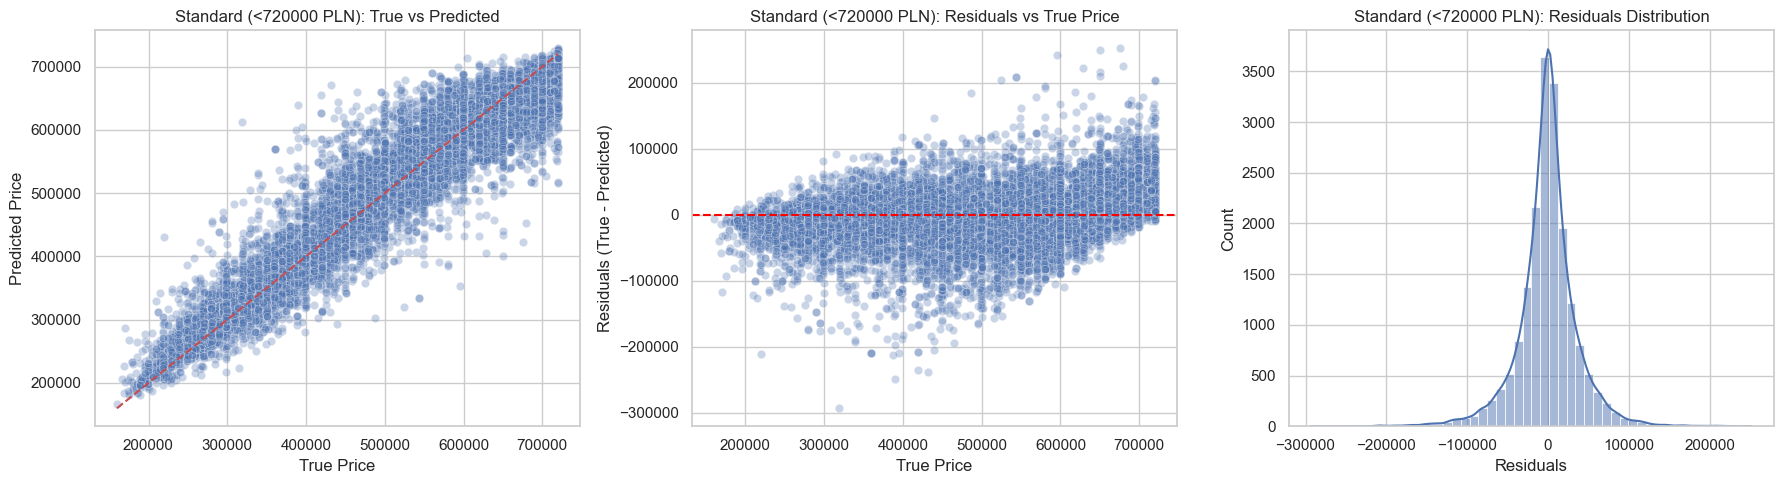

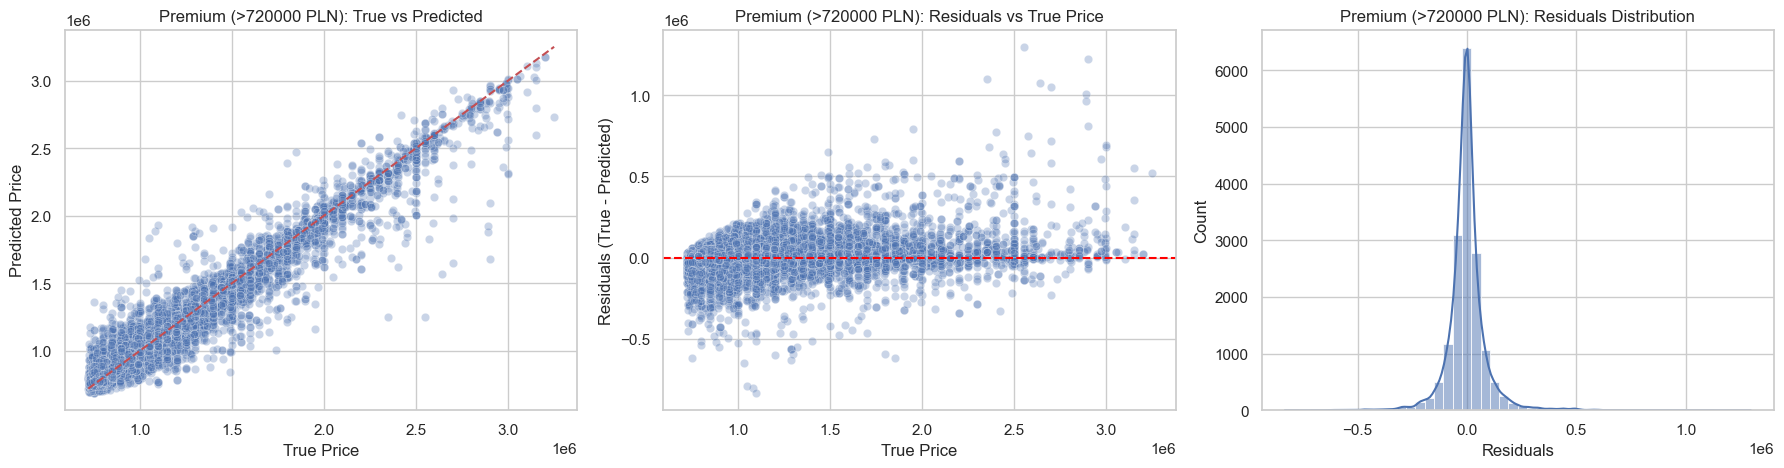

[0]	validation_0-rmse:126825.22726	validation_1-rmse:125908.43001
[1]	validation_0-rmse:117756.11410	validation_1-rmse:116942.92963
[2]	validation_0-rmse:109768.23994	validation_1-rmse:109064.10505
[3]	validation_0-rmse:102737.49112	validation_1-rmse:102127.66751
[4]	validation_0-rmse:96566.89274	validation_1-rmse:96064.30844
[5]	validation_0-rmse:91116.52551	validation_1-rmse:90704.56211
[6]	validation_0-rmse:86334.73078	validation_1-rmse:86024.12775
[7]	validation_0-rmse:82193.58252	validation_1-rmse:81980.66622
[8]	validation_0-rmse:78479.16392	validation_1-rmse:78389.63335
[9]	validation_0-rmse:75274.01990	validation_1-rmse:75328.52309
[10]	validation_0-rmse:72527.43257	validation_1-rmse:72676.49528
[11]	validation_0-rmse:70129.84163	validation_1-rmse:70370.87024
[12]	validation_0-rmse:68046.88766	validation_1-rmse:68390.91771
[13]	validation_0-rmse:66302.11061	validation_1-rmse:66732.13382
[14]	validation_0-rmse:64723.04789	validation_1-rmse:65258.55385
[15]	validation_0-rmse:6325

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [17]:
def plot_results(y_true, y_pred, title):
    residuals = y_true - y_pred

    plt.figure(figsize=(18,5))

    # 1. Scatter plot: True vs Predicted
    plt.subplot(1,3,1)
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True Price')
    plt.ylabel('Predicted Price')
    plt.title(f'{title}: True vs Predicted')

    # 2. Residuals plot: True vs Residuals
    plt.subplot(1,3,2)
    sns.scatterplot(x=y_true, y=residuals, alpha=0.3)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('True Price')
    plt.ylabel('Residuals (True - Predicted)')
    plt.title(f'{title}: Residuals vs True Price')

    # 3. Residuals histogram (error distribution)
    plt.subplot(1,3,3)
    sns.histplot(residuals, bins=50, kde=True)
    plt.xlabel('Residuals')
    plt.title(f'{title}: Residuals Distribution')

    plt.tight_layout()
    plt.show()


# Call for both subsets:
plot_results(y_std_test, y_std_pred, f'Standard (<{threshold} PLN)')
plot_results(y_prm_test, y_prm_pred, f'Premium (>{threshold} PLN)')



eval_set_std = [(X_std_train, y_std_train), (X_std_test, y_std_test)]
eval_set_prm = [(X_prm_train, y_prm_train), (X_prm_test, y_prm_test)]

model_std.fit(
    X_std_train, y_std_train,
    eval_set=eval_set_std,
    #eval_metric="rmse",  # <-- fixed here
    #early_stopping_rounds=20,
    verbose=True
)

model_prm.fit(
    X_prm_train, y_prm_train,
    eval_set=eval_set_prm,
    #eval_metric="rmse",  # <-- fixed here
    #early_stopping_rounds=20,
    verbose=True
)


# After training, access evaluation results:
#results_std = model_std.evals_result()
#results_prm = model_prm.evals_result()

# def plot_training_curve(results, title):
#     epochs = len(results['validation_0']['rmse'])
#     x_axis = range(epochs)

#     plt.figure(figsize=(8,5))
#     plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
#     plt.plot(x_axis, results['validation_1']['rmse'], label='Validation')
#     plt.legend()
#     plt.xlabel('Epochs')
#     plt.ylabel('RMSE')
#     plt.title(f'{title} Training and Validation RMSE')
#     plt.show()

# plot_training_curve(results_std, 'Standard (<1M PLN)')
# plot_training_curve(results_prm, 'Premium (>1M PLN)')

**Using the split function chronologically(time-aware splitting) will allow the model to learn trends etc **

In [18]:

df['date'] = pd.to_datetime(df['date'])        # Ensure proper date format
df = df.sort_values('date')                    # Sort by time

# Threshold to separate Standard and Premium
threshold = 720000

# Define future cutoff (train before, predict after)
cutoff_date = '2024-04-01'
train_df = df[df['date'] < cutoff_date]
future_df = df[df['date'] >= cutoff_date]

# Features to drop from model input
drop_cols = ['price', 'id', 'date', 'is_premium', 'log_price']

# Split by standard vs premium
def prepare_data(df_subset):
    standard = df_subset[df_subset['price'] <= threshold].copy()
    premium = df_subset[df_subset['price'] > threshold].copy()

    X_std = standard.drop(columns=drop_cols)
    y_std = standard['price']

    X_prm = premium.drop(columns=drop_cols)
    y_prm = premium['price']
    
    return X_std, y_std, X_prm, y_prm

X_std_train, y_std_train, X_prm_train, y_prm_train = prepare_data(train_df)
X_std_future, y_std_future, X_prm_future, y_prm_future = prepare_data(future_df)

# XGBoost hyperparameters
best_params = {
    'n_estimators': 500,
    'learning_rate': 0.1,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 1.0,
    'random_state': 42,
    'enable_categorical': True,
    'tree_method': 'hist',
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

# Define and train models
model_std = xgb.XGBRegressor(**best_params)
model_prm = xgb.XGBRegressor(**best_params)

model_std.fit(X_std_train, y_std_train)
model_prm.fit(X_prm_train, y_prm_train)

# Predict future
y_std_future_pred = model_std.predict(X_std_future)
y_prm_future_pred = model_prm.predict(X_prm_future)

# Evaluation function
def print_metrics(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n📊 {name} Model Performance:")
    print(f"MAE:  {mae:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"R²:   {r2:.4f}")

# Report results
print_metrics(y_std_future, y_std_future_pred, f"Standard (>={cutoff_date})")
print_metrics(y_prm_future, y_prm_future_pred, f"Premium (>={cutoff_date})")



📊 Standard (>=2024-04-01) Model Performance:
MAE:  37,535.67
RMSE: 52,864.95
R²:   0.8410

📊 Premium (>=2024-04-01) Model Performance:
MAE:  88,773.77
RMSE: 151,682.46
R²:   0.8733


** Plotting Results **

/var/folders/ss/1qcx7q7n50z1ltqpq2jfcvb40000gn/T/ipykernel_41508/3295473632.py:10: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from current font.
  plt.tight_layout()
/Users/filiporlikowski/Documents/EngeneeringProject/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


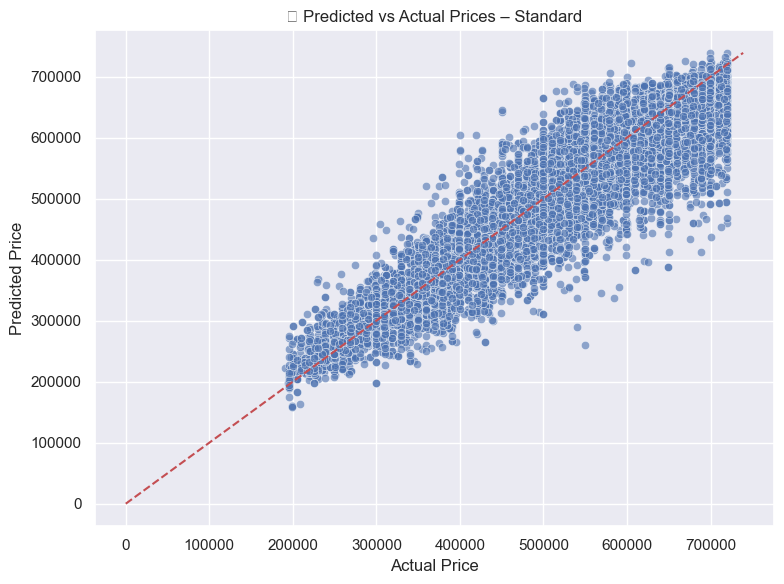

/var/folders/ss/1qcx7q7n50z1ltqpq2jfcvb40000gn/T/ipykernel_41508/3295473632.py:10: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from current font.
  plt.tight_layout()
/Users/filiporlikowski/Documents/EngeneeringProject/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


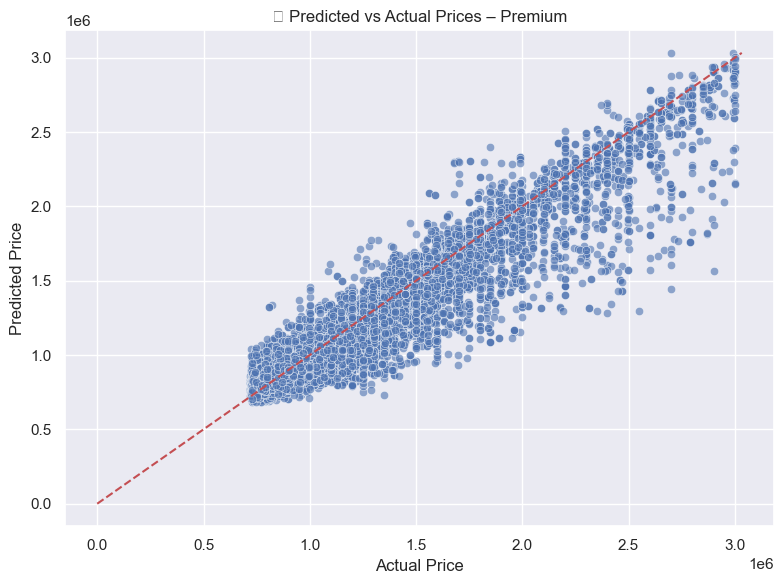

In [36]:
def plot_pred_vs_actual(y_true, y_pred, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([0, max_val], [0, max_val], '--r')  # Diagonal line
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title(f"📌 Predicted vs Actual Prices – {title}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_pred_vs_actual(y_std_future, y_std_future_pred, "Standard")
plot_pred_vs_actual(y_prm_future, y_prm_future_pred, "Premium")

/var/folders/ss/1qcx7q7n50z1ltqpq2jfcvb40000gn/T/ipykernel_41508/3430883401.py:17: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from current font.
  plt.tight_layout()
/Users/filiporlikowski/Documents/EngeneeringProject/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


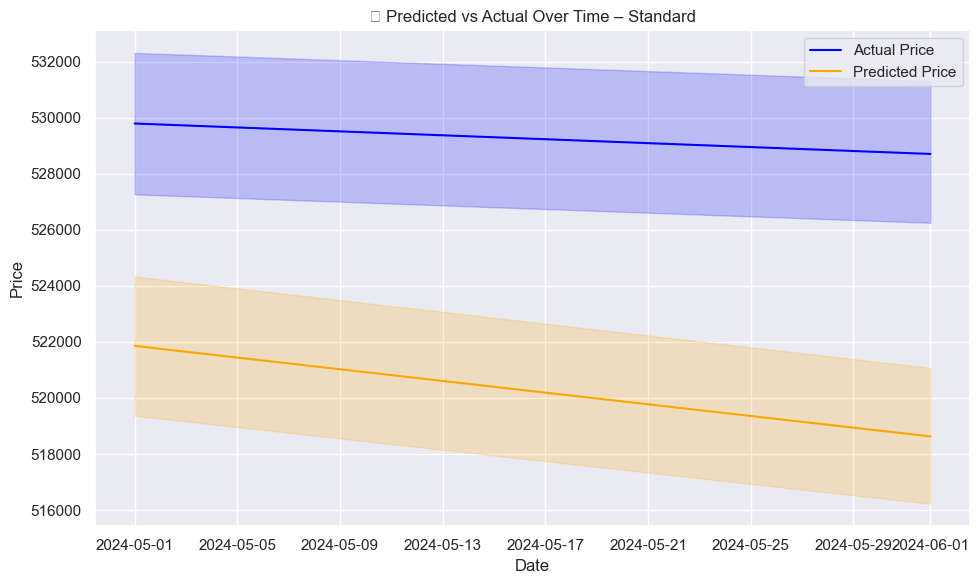

/var/folders/ss/1qcx7q7n50z1ltqpq2jfcvb40000gn/T/ipykernel_41508/3430883401.py:17: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from current font.
  plt.tight_layout()
/Users/filiporlikowski/Documents/EngeneeringProject/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


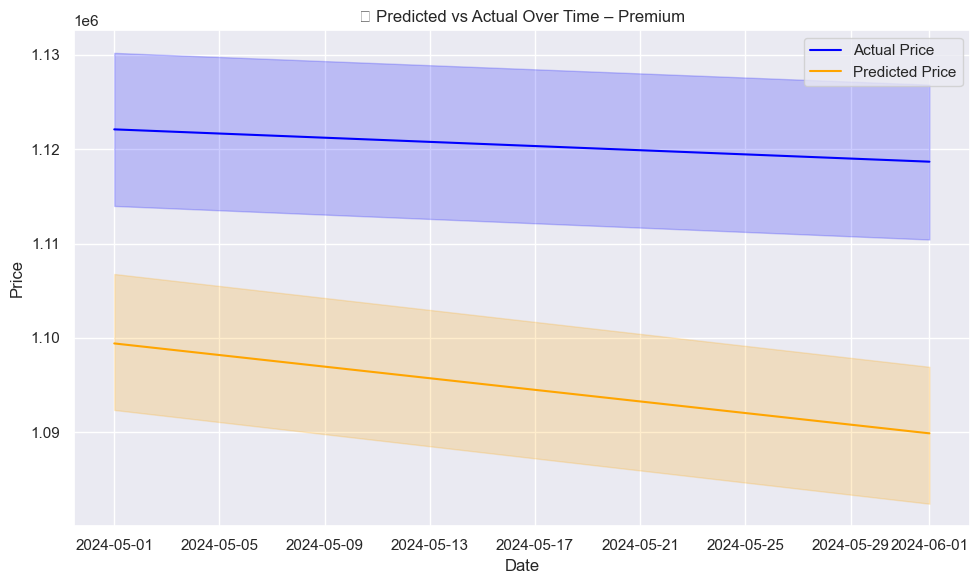

In [37]:
# Add predictions to future_df for plotting
future_df_std = future_df[future_df['price'] <= threshold].copy()
future_df_std['prediction'] = y_std_future_pred

future_df_prm = future_df[future_df['price'] > threshold].copy()
future_df_prm['prediction'] = y_prm_future_pred

def plot_time_series(df, title):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x='date', y='price', label='Actual Price', color='blue')
    sns.lineplot(data=df, x='date', y='prediction', label='Predicted Price', color='orange')
    plt.title(f"📅 Predicted vs Actual Over Time – {title}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_time_series(future_df_std, "Standard")
plot_time_series(future_df_prm, "Premium")


In [38]:
import shap

# Create SHAP explainer for each model
explainer_std = shap.Explainer(model_std)
explainer_prm = shap.Explainer(model_prm)

# Calculate SHAP values for training data (or test data)
shap_values_std = explainer_std(X_std_train)
shap_values_prm = explainer_prm(X_prm_train)

# Summary plot for Standard model
plt.title("SHAP Summary Plot - Standard Model")
shap.summary_plot(shap_values_std, X_std_train, plot_type="bar")

# Summary plot for Premium model
plt.title("SHAP Summary Plot - Premium Model")
shap.summary_plot(shap_values_prm, X_prm_train, plot_type="bar")


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


KeyboardInterrupt: 

In [39]:
print(df)


                                     id  city  type  squareMeters  rooms  \
57835  e991de0d4dff3152a37098dc56b86509     0     3         90.00    4.0   
64726  4ca9b861700b4598db9cc08ce74fa2ef    13     1         58.00    4.0   
64727  508d1c2b12c98b9ac81a1e21bba8b223    13     3         29.52    2.0   
64728  47b654db6ce234affc0e2df3c0b26176    13     3         46.98    2.0   
64729  4976c5c6b2b3b4f34d5e07d6ef041225    13     1         60.00    3.0   
...                                 ...   ...   ...           ...    ...   
14336  501bc49fa4acd39968bf90b6c5a1690c    13     0        105.49    5.0   
14337  95e312e4bedfb7f5e63c425ffdbbd61d    13     2         61.00    3.0   
14338  da8b60611094d2f91c0a43007d28b392    13     1         37.60    2.0   
14340  1cfb1e06f8fe0245c9f5f2828c05596a    13     1         45.40    2.0   
0      811891f98a870dfd6e414374a0a85560    12     1         47.00    2.0   

       floor  floorCount  buildYear   latitude  longitude  ...  \
57835    1.0         

Rigth now I will apply logarithm to the price once again to balance the variance especially in premium prices seegment, and also plot feature importance once again. Check feature importance with:

xgb.plot_importance(model_std)
Then, iterate by:

Removing low-value features


📊 Standard (>=2024-05-01) Model Performance:
MAE:  32,143.13
RMSE: 45,488.28
R²:   0.8804

📊 Premium (>=2024-05-01) Model Performance:
MAE:  79,801.04
RMSE: 136,130.69
R²:   0.8976


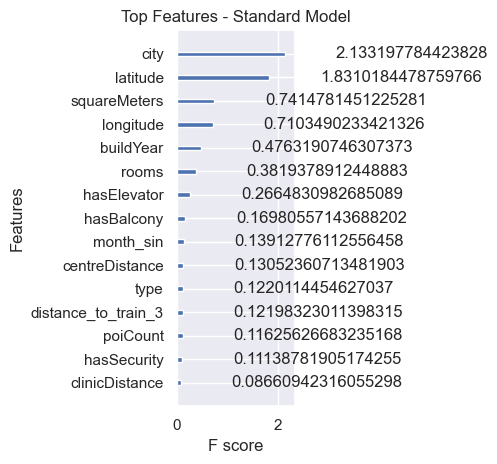

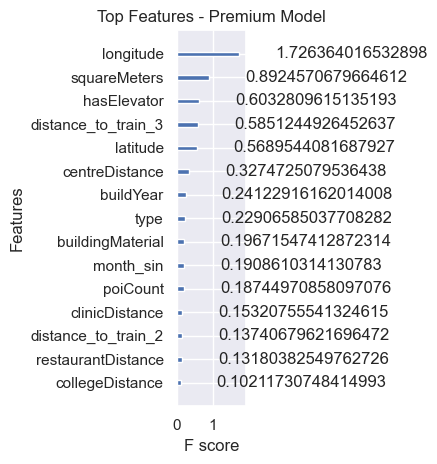

In [40]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Split price bins
threshold = 720000

# Date-based split
cutoff_date = '2024-05-01'
train_df = df[df['date'] < cutoff_date]
future_df = df[df['date'] >= cutoff_date]

# Columns to drop for model input
drop_cols = ['price', 'price_bin', 'id', 'date', 'is_premium', 'log_price']

# Modified prepare_data with log transform option
def prepare_data(df_subset, log_target=False):
    standard = df_subset[df_subset['price'] <= threshold].copy()
    premium = df_subset[df_subset['price'] > threshold].copy()

    X_std = standard.drop(columns=drop_cols)
    y_std = standard['price']
    X_prm = premium.drop(columns=drop_cols)
    y_prm = premium['price']

    if log_target:
        y_std = np.log1p(y_std)
        y_prm = np.log1p(y_prm)

    return X_std, y_std, X_prm, y_prm

# Prepare training and future sets
X_std_train, y_std_train, X_prm_train, y_prm_train = prepare_data(train_df, log_target=True)
X_std_future, y_std_future, X_prm_future, y_prm_future = prepare_data(future_df, log_target=False)

# XGBoost hyperparameters
best_params = {
    'n_estimators': 500,
    'learning_rate': 0.1,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 1.0,
    'random_state': 42,
    'enable_categorical': True,
    'tree_method': 'hist',
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

# Define and train models
model_std = xgb.XGBRegressor(**best_params)
model_prm = xgb.XGBRegressor(**best_params)

model_std.fit(X_std_train, y_std_train)
model_prm.fit(X_prm_train, y_prm_train)

# Predict and inverse log transform
y_std_future_pred = np.expm1(model_std.predict(X_std_future))
y_prm_future_pred = np.expm1(model_prm.predict(X_prm_future))

# Evaluation function
def print_metrics(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n📊 {name} Model Performance:")
    print(f"MAE:  {mae:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"R²:   {r2:.4f}")

# Evaluate future predictions
print_metrics(y_std_future, y_std_future_pred, f"Standard (>={cutoff_date})")
print_metrics(y_prm_future, y_prm_future_pred, f"Premium (>={cutoff_date})")

# Plot feature importance
def plot_importance(model, title):
    xgb.plot_importance(model, max_num_features=15, importance_type='gain', title=title)
    plt.tight_layout()
    plt.show()

plot_importance(model_std, "Top Features - Standard Model")
plot_importance(model_prm, "Top Features - Premium Model")

Why the difference between feature maps and results after log transformation: 

Difference Summary

Aspect	                First Code (log_target=True)	  Second Code (no log)
Target Transformation	Applies np.log1p(price) during training	Uses raw price
Prediction Output	    Applies np.expm1() to return to price scale	Outputs raw predicted price
Why it matters	         Stabilizes variance, reduces skew, helps model focus on relative differences	  Sensitive to outliers, may overfit extreme values
Usage Suitability	    Recommended for skewed price data, esp. Premium	Simpler, works fine if data is normally distributed
Training Example	    Model sees: log(700000) ≈ 13.46	  Model sees: 700000
Prediction Example	Model outputs 13.5 → converts to exp(13.5) ≈ 730000	Model directly outputs 730000



When you log-transform the target:


The loss function shifts from minimizing absolute price error to minimizing error in the log-price domain.
So, features that help predict relative price changes (e.g. “this house is 10% more expensive”) become more important.
Conversely, features that only help in explaining large absolute prices (like lot size in luxury homes) may lose influence in the log space.
🎯 Concrete Effects on Feature Importance

Feature	In raw price model	In log-transformed model
Features strongly associated with large absolute prices (e.g., size, area)	Higher importance	May drop slightly
Features that explain multiplicative changes (e.g., number of amenities, premium indicators)	Medium importance	Likely increase
Outlier-sensitive features (e.g., luxury indicators in a few homes)	High (due to bias)	Lower (log dampens impact)
Stable predictors across price tiers	Moderate	Higher in log model (more consistent behavior)
🧪 Example:

Let’s say:

In raw price model: size gets 40% importance, neighborhood_quality gets 5%
In log-transformed model: size drops to 25%, neighborhood_quality jumps to 15%
This tells you:

size explains big jumps in price, but less so the relative variance
neighborhood_quality helps explain why some homes are priced 20% higher — something better captured on a log scale
🧭 What Should You Do?

✅ Train both versions (log and raw)
✅ Compare their plot_importance() maps
🔍 Ask:
Are the top features stable across both?
Are there some features that only shine in the log model?
Are some features only helpful at extreme prices?